# Solution - Project
For this project, let's assume that we have measured the brain volumes for all 400 images in the OASIS dataset and stored them in a csv file. We have also access to all image data sets.

This demo is a jupyter notebook, i.e. intended to be run step by step.

Author: Eric Einspänner
<br>
Contributor: Nastaran Takmilhomayouni

First version: 6th of July 2023

Copyright 2023 Clinic of Neuroradiology, Magdeburg, Germany

License: Apache-2.0

## Project description - Part I
For this project part we are using the data stored in a csv file.

With this data, we want to answer some crucial questions:
- Is there strong evidence that Alzheimer's Disease characterized by reduced brain volume?
- Is there strong evidence that Alzheimer's Disease is marked by smaller brain size, relative to skull size?


For this question, we can use a two-sample t-test. We will test the null hypothesis that the mean brain volumes shrinks due to Alzheimer's. The likelihood of the null hypothesis being true is assessed by calculating the t-statistic. If the magnitude of t is very far from 0, then we can reject the null hypothesis that the groups are the same.

### 1. Import Python libraries

In [ ]:
# Make sure figures appears inline and animations works
# Edit this to ""%matplotlib notebook" when using the "classic" jupyter notebook interface
%matplotlib widget

In [3]:
# Used to change filepaths
from pathlib import Path

# We set up matplotlib and the display function
import matplotlib.pyplot as plt
from IPython.display import display

# import numpy, pandas, pydicom and ...
import numpy as np
import pandas as pd
import pydicom

import os
import SimpleITK
import scipy.ndimage as ndi
import imageio.v2 as imageio
import nibabel as nb

### 2. Import and read the dataset

In [24]:
# Load OASIS csv file
df = pd.read_csv('../files/oasis_all_volumes.csv', index_col=0)

### 3. Check the dataset

In [ ]:
# Print the first five rows of the table
print(df.head())

# Print prevalence of Alzheimer's Disease
print(df.alzheimers.value_counts())

# Print a correlation table excluding non-numeric columns
print(df.select_dtypes(include='number').corr())

### 4. Testing Group Differences
Let's test the hypothesis that Alzheimer's Disease is characterized by reduced brain volume. To run the t-test, we need the brain volumes for all patients with diagnosed Alzheimer's and without in our sample. Select the 'alzheimers' values with `df.loc`, then specifying the column with "brain volume" values. For the healthy cohort, we change the selected value to 'False'. To run the t-test, import the `ttest_ind()` function from SciPy's stats module. Then, pass the two vectors as our first and second populations. The results object contains the test statistic and the p-value. The p-value corresponds to the probability that the null hypothesis is true.

In this case, the two population samples are independent from each other because they are all separate subjects.

For this exercise, use the OASIS dataset (`df`) and `ttest_ind` to evaluate the hypothesis.

In [ ]:
# Import independent two-sample t-test
from scipy.stats import ttest_ind

To better understand the function `ttest_ind` try to get more information about `ttest_ind` with the `help()` function. Which parameters does the function need? What is the output?

In [ ]:
help(ttest_ind)

Use DataFrame operations to extract brain volume data for Alzheimer's and typical groups for the column `brain_vol`.

In [ ]:
# Select data from "alzheimers" and "typical" groups
brain_alz = df.loc[df.alzheimers == True, 'brain_vol']
brain_typ = df.loc[df.alzheimers == False, 'brain_vol']

We can now perform a two-sample t-test between the brain volumes of elderly adults with and without Alzheimer's Disease. Using `results.statistic` and `results.pvalue` as your guide, answer the question: Is there strong evidence that Alzheimer's Disease is marked by smaller brain size?

In [ ]:
# Perform t-test of "alz" > "typ"
results = ttest_ind(brain_alz, brain_typ)
print('t = ', results.statistic)
print('p = ', results.pvalue)

Solution: There is some evidence for decreased brain volume in individuals with Alzheimer's Disease. Since the p-value for this t-test is greater than 0.05, we would not reject the null hypothesis that states the two groups are equal.

Visualize the distribution of brain volumes based on whether individuals have Alzheimer's disease or not.

In [ ]:
# Show boxplot of brain_vol differences
df.boxplot(column='brain_vol', by='alzheimers')
plt.show()

### 5. Normalizing metrics
We previously saw that there was not a significant difference between the brain volumes of elderly individuals with and without Alzheimer's Disease. To account for this potential confound, we can normalize brain volume with respect to skull size by calculating the brain to skull ratio.

But could a correlated measure, such as "skull volume" be masking the differences?

For this exercise, calculate a new test statistic for the comparison of brain volume between groups, after adjusting for the subject's skull size.

In [ ]:
# Adjust `brain_vol` by `skull_vol`
df['adj_brain_vol'] = df.brain_vol / df.skull_vol

Use DataFrame operations to extract brain volume data for Alzheimer's and typical groups for the new column `adj_brain_vol` and perform a two-sample t-test between the brain volumes of elderly adults with and without Alzheimer's Disease. The statistics and the p-value would be interesting here (print statistic and p value).

Using `results.statistic` and `results.pvalue` as your guide, answer the question: Is there strong evidence that Alzheimer's Disease is marked by smaller brain size, relative to skull size?

In [ ]:
# Select brain measures by group
brain_alz = df.loc[df.alzheimers == True, 'adj_brain_vol']
brain_typ = df.loc[df.alzheimers == False, 'adj_brain_vol']

# Evaluate null hypothesis
results = ttest_ind(brain_alz, brain_typ)
print('t = ', results.statistic)
print('p = ', results.pvalue)

Solution: Yes, reject the null hypothesis! Based on the results.statistic and results.pvalue.

## Project description - Part II
In this part of the project, we want to work with medical image datasets.

Load one OASIS dataset. 
Try to generate a new dataset by :
<br>
    1-changing the scan day
<br>
    2-applying one manual modification ( affine transformation, DICOM header modification)
<br>
At the end you'll have two datasets of one patient

### 1- Load both datasets
Load datasets with pydicom. print and compare DICOM headers.
When was the scan date/time of each dataset?
<br>
you can use pydicom python package

In [7]:
# Load the directory (volume)
# Load the directory (volume)
folder_path = '../files/Day1/MR000000'
dcm = pydicom.dcmread(folder_path)

folder_path2 ='../files/Day2/MR000000_2'
dcm2 = pydicom.dcmread(folder_path2)

In [8]:
print('Study Date of the first image is:',dcm.StudyDate)
print('Series Date of the first image is:',dcm.SeriesDate)
print('Acquisition Date of the first image is:',dcm.AcquisitionDate)
print('Content Date of the first image is:',dcm.ContentDate)
print('Instance Creation Date of the first image is:',dcm.InstanceCreationDate)
#--------------------------------------------------------------
print('Instance Creation of the first image Time is:',dcm.InstanceCreationTime)
print('Study Time of the first image is:',dcm.StudyTime)
print('Series Time of the first image is:',dcm.SeriesTime)
print('Acquisition Time of the first image is:',dcm.AcquisitionTime)
print('Content Time of the first image is:',dcm.ContentTime)

Study Date of the first image is: 20150114
Series Date of the first image is: 20150114
Acquisition Date of the first image is: 20150114
Content Date of the first image is: 20150114
Instance Creation Date of the first image is: 20150114
Instance Creation of the first image Time is: 132938
Study Time of the first image is: 132242
Series Time of the first image is: 132628.00000
Acquisition Time of the first image is: 132628.00
Content Time of the first image is: 132628.00


In [9]:
print('Study Date of the second image is:',dcm2.StudyDate)
print('Series Date of the second image is:',dcm2.SeriesDate)
print('Acquisition Date of the second image is:',dcm2.AcquisitionDate)
print('Content Date of the second image is:',dcm2.ContentDate)
print('Instance Creation Date of the second image is:',dcm2.InstanceCreationDate)
#--------------------------------------------------------------
print('Instance Creation Time of the second image is:',dcm2.InstanceCreationTime)
print('Study Time of the second image is:',dcm2.StudyTime)
print('Series Time of the second image is:',dcm2.SeriesTime)
print('Acquisition of the second image Time is:',dcm2.AcquisitionTime)
print('Content Time of the second image is:',dcm2.ContentTime) 

Study Date of the second image is: 20150315
Series Date of the second image is: 20150315
Acquisition Date of the second image is: 20150315
Content Date of the second image is: 20150315
Instance Creation Date of the second image is: 20150315
Instance Creation Time of the second image is: 143709
Study Time of the second image is: 143003
Series Time of the second image is: 143435.00000
Acquisition of the second image Time is: 143435.00
Content Time of the second image is: 143435.00


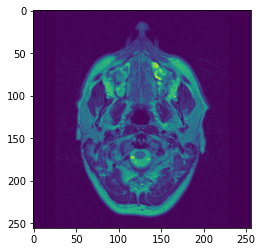

In [10]:
plt.imshow(dcm.pixel_array)

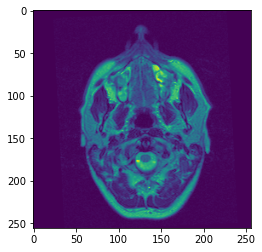

In [11]:
plt.imshow(dcm2.pixel_array)

### 2- Convert DICOM to NIfTI
Convert DICOM dataset to NIfTI format using nibabel python package

In [12]:
import SimpleITK as sitk

reader = sitk.ImageSeriesReader()
dicom_names = reader.GetGDCMSeriesFileNames('../files/Day1')
print(dicom_names)
reader.SetFileNames(dicom_names)
image = reader.Execute()
print(image)
sitk.WriteImage(image, '../files/Day1/MR.nii')


reader = sitk.ImageSeriesReader()
dicom_names = reader.GetGDCMSeriesFileNames('../files/Day2')
print(dicom_names)
reader.SetFileNames(dicom_names)
image = reader.Execute()
print(image)
sitk.WriteImage(image, '../files/Day2/MR-2.nii')


('../files/Day1/MR000000', '../files/Day1/MR000001', '../files/Day1/MR000002', '../files/Day1/MR000003', '../files/Day1/MR000004', '../files/Day1/MR000005', '../files/Day1/MR000006', '../files/Day1/MR000007', '../files/Day1/MR000008', '../files/Day1/MR000009', '../files/Day1/MR000010', '../files/Day1/MR000011', '../files/Day1/MR000012', '../files/Day1/MR000013', '../files/Day1/MR000014', '../files/Day1/MR000015', '../files/Day1/MR000016', '../files/Day1/MR000017', '../files/Day1/MR000018', '../files/Day1/MR000019', '../files/Day1/MR000020', '../files/Day1/MR000021', '../files/Day1/MR000022', '../files/Day1/MR000023', '../files/Day1/MR000024', '../files/Day1/MR000025', '../files/Day1/MR000026')
Image (000002521EB7C570)
  RTTI typeinfo:   class itk::Image<unsigned short,3>
  Reference Count: 1
  Modified Time: 1882
  Debug: Off
  Object Name: 
  Observers: 
    none
  Source: (none)
  Source output name: (none)
  Release Data: Off
  Data Released: False
  Global Release Data: Off
  Pipel

### 3- Plot average slice
Plot average slices of two images using subplot

(256, 256, 27)
(256, 256, 27)


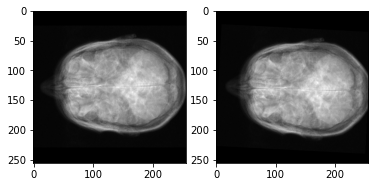

In [13]:
img1=nb.load('../files/Day1/MR.nii')
img2=nb.load('../files/Day2/MR-2.nii')
img1_data=img1.get_fdata()
img2_data=img2.get_fdata()
print(np.shape(img1_data))
print(np.shape(img2_data))

img1_avg_data=np.average(img1_data,axis=2)
img2_avg_data=np.average(img2_data,axis=2)

plt.subplot(1,2,1)
plt.imshow(img1_avg_data,cmap='gray')
plt.subplot(1,2,2)
plt.imshow(img2_avg_data,cmap='gray')

### 4- Image Comparison
Compare two images using MAE, SSIM and IoU

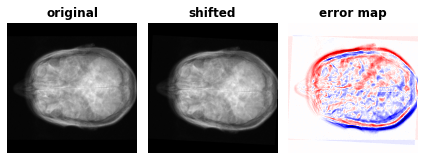

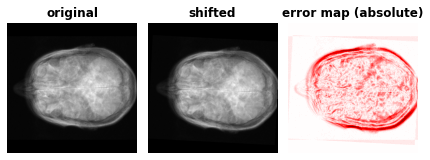

MAE: 14.88793549714265


In [14]:
def format_and_render_plot():
    '''
    Custom function to simplify common formatting operations for exercises. Operations include: 
    1. Turning off axis grids.
    2. Calling `plt.tight_layout` to improve subplot spacing.
    3. Calling `plt.show()` to render plot.
    '''
    fig = plt.gcf()
    for ax in fig.axes:
        ax.axis('off')    
    plt.tight_layout()
    plt.show()


# Calculate image difference
err = img1_avg_data - img2_avg_data

# Plot the difference
fig, axes = plt.subplots(1, 3)
axes[0].imshow(img1_avg_data, cmap='gray')
axes[0].set_title('original', fontweight ="bold")
axes[1].imshow(img2_avg_data, cmap='gray')
axes[1].set_title('shifted', fontweight ="bold")
axes[2].imshow(err, cmap='seismic', vmin=-200, vmax=200)
axes[2].set_title('error map', fontweight ="bold")
format_and_render_plot()

# Calculate absolute image difference
abs_err = np.absolute(img1_avg_data - img2_avg_data)

# Plot the difference
fig, axes = plt.subplots(1, 3)
axes[0].imshow(img1_avg_data, cmap='gray')
axes[0].set_title('original', fontweight ="bold")
axes[1].imshow(img2_avg_data, cmap='gray')
axes[1].set_title('shifted', fontweight ="bold")
axes[2].imshow(abs_err, cmap='seismic', vmin=-200, vmax=200)
axes[2].set_title('error map (absolute)', fontweight ="bold")
format_and_render_plot()

# Calculate mean absolute error
mean_abs_err = np.mean(np.abs(img1_avg_data - img2_avg_data))
print('MAE:', mean_abs_err)

In [15]:
from skimage.metrics import structural_similarity as ssim

# Compute SSIM between im and xfm
data_range=img2_avg_data.max() - img2_avg_data.min()
ssim_index = ssim(img1_avg_data, img2_avg_data, data_range=data_range)

print(f'SSIM: {ssim_index}')

SSIM: 0.6059416627155653


In [16]:
def intersection_of_union(im1, im2):
    i = np.logical_and(im1, im2)
    u = np.logical_or(im1, im2)
    return i.sum() / u.sum()

# Try some other paramters by yourself
img2_avg_data = ndi.shift(img1_avg_data, shift=(-10, -10))
img2_avg_data = ndi.rotate(img2_avg_data, angle=-15, reshape=False)
intersection_of_union(img2_avg_data, img1_avg_data)

0.8246249012898131

### 5- Image Registration
Register first image on second image using affine registration using affine registration

In [17]:
import SimpleITK as sitk
#import SimpleITK-SimpleElastix as sitk

elastixImageFilter = sitk.ElastixImageFilter()
elastixImageFilter.SetFixedImage(sitk.ReadImage('../files/Day1/MR.nii'))
elastixImageFilter.SetMovingImage(sitk.ReadImage('../files/Day2/MR-2.nii'))
elastixImageFilter.SetParameterMap(sitk.GetDefaultParameterMap("affine"))
elastixImageFilter.Execute()
elastixImageFilter.GetResultImage()

<SimpleITK.SimpleITK.Image; proxy of <Swig Object of type 'std::vector< itk::simple::Image >::value_type *' at 0x000002523D3C5AB0> >

In [18]:
from dipy.align.transforms import AffineTransform3D
from dipy.align.imaffine import AffineRegistration
affreg = AffineRegistration()
transform = AffineTransform3D()
affine = affreg.optimize(img1_data, img2_data, transform, params0=None)

Optimizing level 2 [max iter: 10000]
Optimizing level 1 [max iter: 1000]
Optimizing level 0 [max iter: 100]


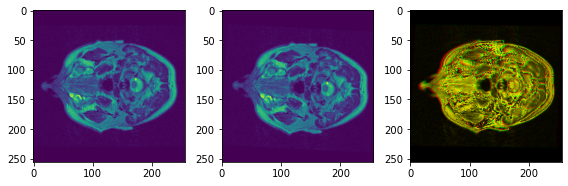

In [19]:
img2_data_xform = affine.transform(img2_data)

fig, axes = plt.subplots(1, 3, figsize=(8, 4))
ax = axes.ravel()

ax[0].imshow(img1_data[:,:,0])
ax[1].imshow(img2_data[:,:,0])

stereo = np.zeros((256, 256, 3), dtype=np.uint8)
stereo[..., 0] = img1_data[:,:,0]
stereo[..., 1] = img2_data_xform[:,:,0]
ax[2].imshow(stereo)
fig.tight_layout()

In [ ]:
#MSE SSIM Iod  und die Linke von transformations